In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import argparse
import sys
import os
import csv
import matplotlib.pyplot as plt
import scipy.stats as ss
import pickle

# Add the path to the directory containing the file
sys.path.append(os.path.abspath('../benchmarking/'))
from utils import *


## Load in data

In [2]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"
pairs_path = f"{data_path}/protein_data/pairs_training.csv"
coord_path = f"{data_path}/protein_data/allCACoord.npz"
nh_path = f"{data_path}/blurry_vec/nHot.npz"
tmat_path = f"{data_path}/blurry_vec/transition_mtx.npy"

In [3]:
coord_d = np.load(coord_path)
# how long is each protein
name_to_length_d ={}
for key in coord_d.keys():
    name_to_length_d[key]= coord_d[key].shape[0]

In [4]:
# remove anything with 'd1e25a_' since we seem to be having some length issues
# remove any pairs with length > 512 

pairs = []
alns_as_lists_d = {}
first = True

bad_list = ['d1e25a_','d1o7d.2','d1o7d.3']

with open(pairs_path, mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        pair = (row[1],row[2])
        if first:
            first = False
            continue    
        elif pair[0] in bad_list or pair[1] in bad_list:
            continue
        elif name_to_length_d[pair[0]]>512 or name_to_length_d[pair[1]]>512:
            continue
        else:
            pairs.append(pair)
            alns_as_lists_d[pair]=[int(i) for i in row[-1].strip('[]').split()]

print(len(pairs))

134147


In [5]:
def random_subsample(original_list, percentage=0.2):
    # Calculate the number of items to select
    num_to_select = max(1, int(len(original_list) * percentage))  # Ensure at least one item is selected
    
    # Randomly select indices
    np.random.seed(0)
    selected_indices = sorted(np.random.choice(range(len(original_list)), num_to_select))
    
    # Create the subsample based on selected indices
    subsample = [original_list[i] for i in selected_indices]
    return subsample



In [6]:
# take 10% of the pairs
pairs = random_subsample(pairs, percentage = 0.1)


## Compute counts of Jaccard scores

In [7]:
def aln_list_to_tensor(l1, l2, aln_list):
    tensor = jnp.zeros(shape= (l1,l2))
    pairs = [(index, value) for index, value in enumerate(aln_list) if value != -1]
    indices = jnp.array([i for i, _ in pairs])
    values = jnp.array([j for _, j in pairs])
    tensor = tensor.at[indices, values].set(1)
    return tensor

In [8]:
nhot_d = dict(np.load(nh_path))
for key in nhot_d.keys():
    nhot_d[key]= jnp.array(nhot_d[key]).astype(float)
transition_mtx = np.load(tmat_path)

In [9]:
%%time
aln_tensors = []
sim_tensors = []
for i, pair in enumerate(pairs):
    if i%100 == 0: print(i)
    aln_tensors.append(aln_list_to_tensor(name_to_length_d[pair[0]], name_to_length_d[pair[1]], alns_as_lists_d[pair]))
    sim_tensors.append(sim_mtx_blurry(nhot_d[pair[0]], nhot_d[pair[1]], transition_mtx))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700


E1106 22:39:00.670330 2625416 hlo_lexer.cc:443] Failed to parse int literal: 38597865927171870947


12800
12900
13000
13100
13200
13300
13400
CPU times: user 29min 36s, sys: 1min 44s, total: 31min 21s
Wall time: 39min 11s


In [10]:
#pickle.dump((aln_tensors,sim_tensors), open("aln_and_sim_tensors.pkl","wb") )

In [7]:
aln_tensors,sim_tensors = pickle.load( open("aln_and_sim_tensors.pkl","rb") )

In [8]:
jaccards = []
aln_pos = []
for i in range(len(pairs)):
    if i%100 == 0: print(i)
    jaccards+=list(np.array(sim_tensors[i]).flatten())
    aln_pos+=list(np.array(aln_tensors[i]).flatten())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400


In [9]:
# number of aligned positions
p = sum(aln_pos)/len(aln_pos)
print(p)

0.00420188


In [10]:
# jaccards at the aligned positions
aln_jaccards = [jaccards[i] for i in range(len(jaccards)) if aln_pos[i]==1]

In [11]:
print(sum(aln_pos),len(aln_jaccards)) #should be equal

1621766.0 1621766


In [12]:
sum(aln_pos)==len(aln_jaccards) #should be true

np.True_

In [13]:
def create_count_list(values, lb=0, ub=1, num_bins=100):
    # Create 100 bins between 0 and 1 (or as specified by num_bins)
    bin_edges = list(np.linspace(lb, ub, num_bins + 1))
    #bin_edges = [0]+list(np.linspace(lb, ub, num_bins + 1))+[1.0]  # 101 bin edges for 100 bins
    print(bin_edges)
    # Compute the histogram
    counts, _ = np.histogram(values, bins=bin_edges)   
    return counts

In [14]:
nbins =100
aln_counts = create_count_list(aln_jaccards, 0, 1)
total_counts = create_count_list(jaccards)

[np.float64(0.0), np.float64(0.01), np.float64(0.02), np.float64(0.03), np.float64(0.04), np.float64(0.05), np.float64(0.06), np.float64(0.07), np.float64(0.08), np.float64(0.09), np.float64(0.1), np.float64(0.11), np.float64(0.12), np.float64(0.13), np.float64(0.14), np.float64(0.15), np.float64(0.16), np.float64(0.17), np.float64(0.18), np.float64(0.19), np.float64(0.2), np.float64(0.21), np.float64(0.22), np.float64(0.23), np.float64(0.24), np.float64(0.25), np.float64(0.26), np.float64(0.27), np.float64(0.28), np.float64(0.29), np.float64(0.3), np.float64(0.31), np.float64(0.32), np.float64(0.33), np.float64(0.34), np.float64(0.35000000000000003), np.float64(0.36), np.float64(0.37), np.float64(0.38), np.float64(0.39), np.float64(0.4), np.float64(0.41000000000000003), np.float64(0.42), np.float64(0.43), np.float64(0.44), np.float64(0.45), np.float64(0.46), np.float64(0.47000000000000003), np.float64(0.48), np.float64(0.49), np.float64(0.5), np.float64(0.51), np.float64(0.52), np.flo

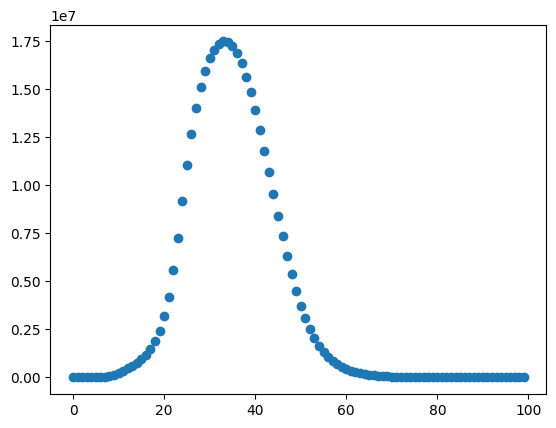

In [15]:
plt.scatter(range(nbins), total_counts)

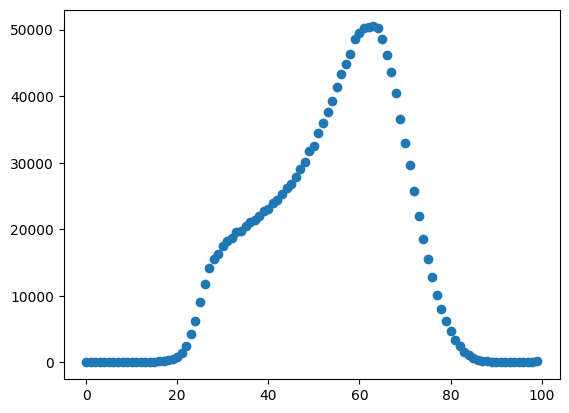

In [16]:
plt.scatter(range(nbins), aln_counts)

/tmp/ipykernel_2705860/207561450.py:1: RuntimeWarning: invalid value encountered in scalar divide
  plt.scatter(range(nbins), [aln_counts[i]/total_counts[i] for i in range(nbins)])


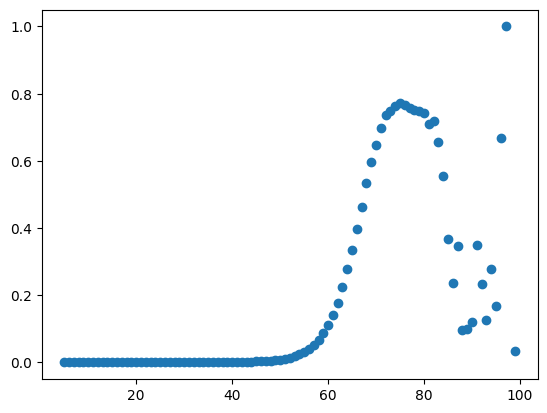

In [17]:
plt.scatter(range(nbins), [aln_counts[i]/total_counts[i] for i in range(nbins)])

/tmp/ipykernel_2705860/461294496.py:1: RuntimeWarning: invalid value encountered in scalar divide
  plt.scatter(range(nbins), [aln_counts[i]/total_counts[i] for i in range(nbins)])


(0.0, 0.01)

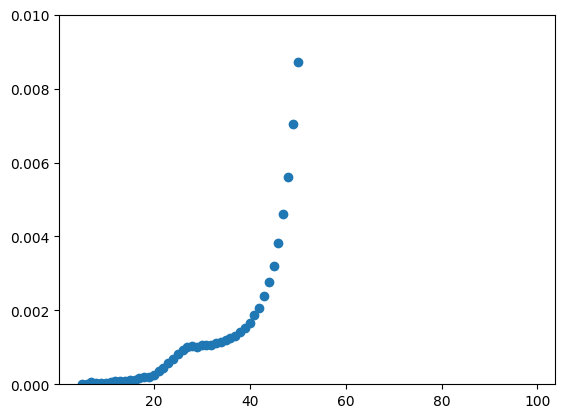

In [18]:
plt.scatter(range(nbins), [aln_counts[i]/total_counts[i] for i in range(nbins)])
plt.ylim(0,.01)

## Make BLOSUM matrix

In [19]:
blosum = []
for i in range(nbins):
    blosum.append(2* (jnp.log(aln_counts[i]/total_counts[i])-jnp.log(p)).item())

/tmp/ipykernel_2705860/2214760657.py:3: RuntimeWarning: invalid value encountered in scalar divide
  blosum.append(2* (jnp.log(aln_counts[i]/total_counts[i])-jnp.log(p)).item())


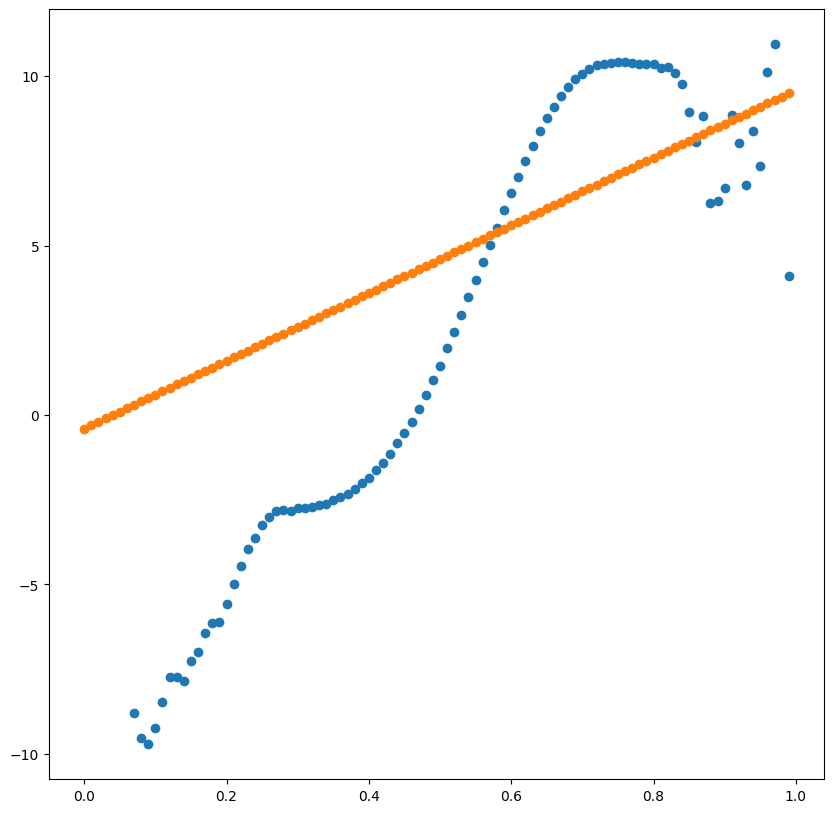

In [20]:
# comparison to linear scheme
plt.figure(figsize = (10,10))
plt.scatter([i/nbins for i in range(nbins)], blosum)
plt.scatter([i/nbins for i in range(nbins)], [i/10-.4 for i in range(nbins)])

In [27]:
np.argmax(blosum[8:-5])+8

np.int64(75)

In [40]:
# manual interpolation since we probably have some low count issues
blosum_new = np.zeros(100)
# no data here; set to lowest value
for i in range(8):
    blosum_new[i] = blosum[8]
# linearly interpolate in the noisy zone
diff = blosum[25]-blosum[8]
for i in range(8,25):
    blosum_new[i]= (i-8)/(25-8)*diff + blosum[8]
# keep middle the same
for i in range(25,100-25):
    blosum_new[i]= blosum[i]
# make values >.75 all equal to the highest score
for i in range(100-25,100):
    blosum_new[i] = blosum[100-25]+.5


In [41]:
blosum_int = np.round(blosum_new).astype(int)

In [42]:
blosum_int

array([-10, -10, -10, -10, -10, -10, -10, -10, -10,  -9,  -9,  -8,  -8,
        -8,  -7,  -7,  -7,  -6,  -6,  -5,  -5,  -5,  -4,  -4,  -4,  -3,
        -3,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -2,  -2,  -2,
        -2,  -2,  -2,  -1,  -1,  -1,  -1,   0,   0,   1,   1,   1,   2,
         2,   3,   3,   4,   5,   5,   6,   6,   7,   7,   7,   8,   8,
         9,   9,   9,  10,  10,  10,  10,  10,  10,  10,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11])

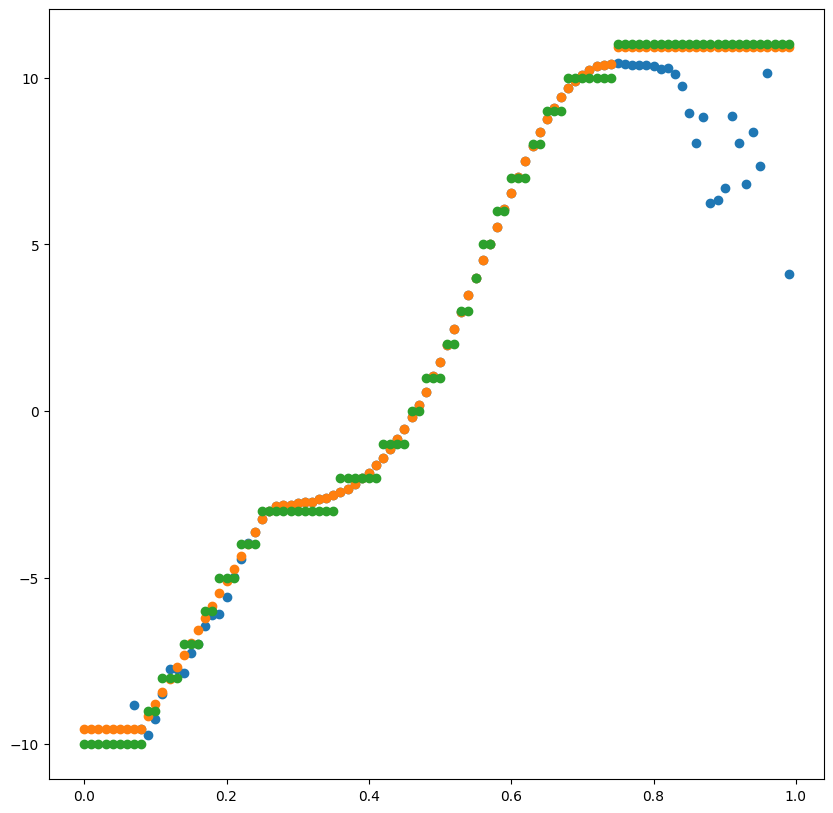

In [43]:
plt.figure(figsize = (10,10))
plt.scatter([i/nbins for i in range(nbins)], blosum)
plt.scatter([i/nbins for i in range(nbins)], blosum_new)
plt.scatter([i/nbins for i in range(nbins)], blosum_int)

In [45]:
np.save(f"{data_path}/blurry_vec/jaccard_blosum_int.npy", blosum_int)

## compute lambda and k

In [46]:
from compute_lambda_and_k import *

In [47]:
probs_of_each_bin = total_counts/sum(total_counts)
low = np.min(blosum_int)
high = np.max(blosum_int)
probs = np.zeros(high-low +1)
for i in range(blosum_int.shape[0]):   
    probs[blosum_int[i]-low] += probs_of_each_bin[i]
       
lam, k = call_karlin(low, high, probs)
print(lam,k)

0.4979534447193146 0.2038358684518311


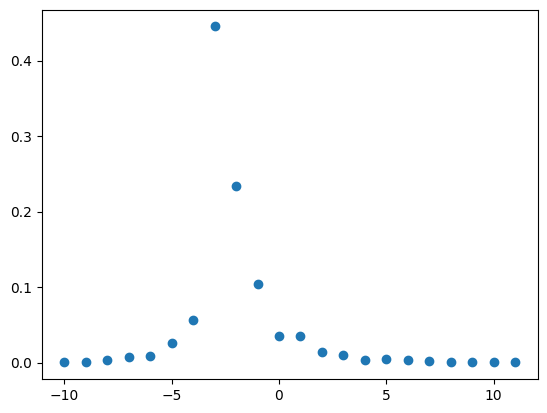

In [48]:
plt.scatter(range(low,high+1), probs)